## ARIMAで5日分を予測し、観測値・予測値をカテゴリーに分類した上で精度を計る  

2つのやり方で精度比較をする  
1. 1時間おきにカテゴリー変換をして精度比較  
2. 6時間おきに値の平均を取りカテゴリー変換をして精度比較

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
%matplotlib inline

In [165]:
#trainデータ
#df=pd.read_csv("/Users/masanoritakahashi/Documents/forecast_PM2.5/modefied_data/rohini_1016_6hours.csv").iloc[:,1:]
#検証用データ
#test=pd.read_csv("/Users/masanoritakahashi/Documents/forecast_PM2.5/modefied_data/rohini_1113_6hours.csv").iloc[:,1:]

In [166]:
df=pd.read_csv("/Users/masanoritakahashi/Documents/aqi/modefieddata/rohini_1015.csv").iloc[:,1:]

In [167]:
df

,rohini,utc_time
0,19.0,2019-07-17 00:00:00
1,27.0,2019-07-17 01:00:00
2,13.0,2019-07-17 02:00:00
3,9.0,2019-07-17 03:00:00
4,12.0,2019-07-17 04:00:00
...,...,...
1900,61.0,2019-10-04 04:00:00
1901,51.0,2019-10-04 05:00:00
1902,46.0,2019-10-04 06:00:00
1903,42.0,2019-10-04 07:00:00


In [70]:
df.isnull().sum()

rohini      105
utc_time      0
dtype: int64

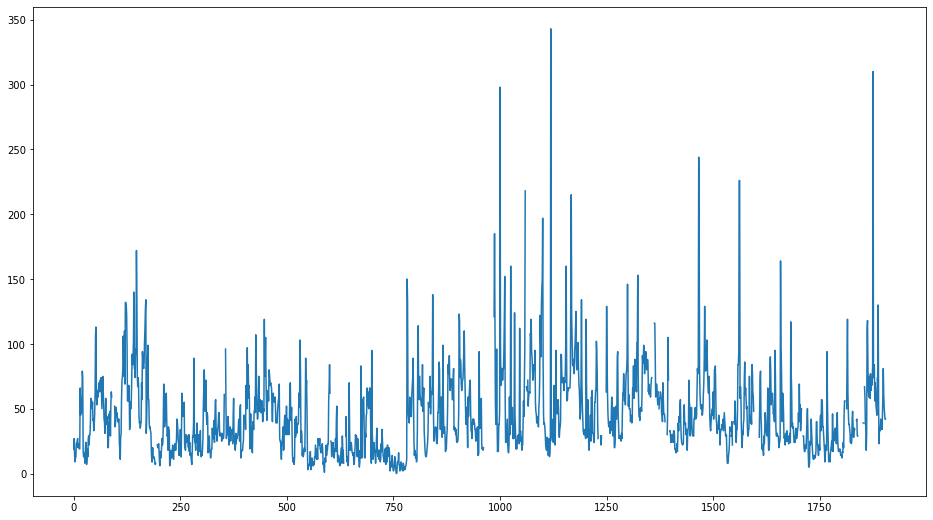

In [72]:
plt.figure(figsize=(16,9))
plt.plot(df["rohini"])

In [80]:
#7/17 00:00〜09/29 08:00までをtrain
train=df[:-120]
#09/29 09:00　〜 10/04 08:00までの5日間を予測
test=df[-120:]

In [81]:
train.head()

,rohini,utc_time
0,19.0,2019-07-17 00:00:00
1,27.0,2019-07-17 01:00:00
2,13.0,2019-07-17 02:00:00
3,9.0,2019-07-17 03:00:00
4,12.0,2019-07-17 04:00:00


In [82]:
train.tail()

,rohini,utc_time
1780,46.0,2019-09-29 04:00:00
1781,17.0,2019-09-29 05:00:00
1782,30.0,2019-09-29 06:00:00
1783,25.0,2019-09-29 07:00:00
1784,31.0,2019-09-29 08:00:00


In [75]:
test.head()

,rohini,utc_time
1785,34.0,2019-09-29 09:00:00
1786,35.0,2019-09-29 10:00:00
1787,35.0,2019-09-29 11:00:00
1788,27.0,2019-09-29 12:00:00
1789,23.0,2019-09-29 13:00:00


In [76]:
test.tail()

,rohini,utc_time
1900,61.0,2019-10-04 04:00:00
1901,51.0,2019-10-04 05:00:00
1902,46.0,2019-10-04 06:00:00
1903,42.0,2019-10-04 07:00:00
1904,42.0,2019-10-04 08:00:00


In [106]:
f=lambda x:datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

train["utc_time"]=train["utc_time"].apply(f)
test["utc_time"]=test["utc_time"].apply(f)

In [107]:
ts=train["rohini"].interpolate('linear')
ts.index=train["utc_time"]

ts_test=test["rohini"].interpolate('linear')
ts_test.index=test["utc_time"]

# ADF 検定  
単位根過程（非定常過程）かどうかの検定  
時系列解析は定常性が鍵  
→p値　が5%以下ならば定常と言える

In [89]:
res_ctt=sm.tsa.stattools.adfuller(ts, regression="ctt")
res_ct=sm.tsa.stattools.adfuller(ts, regression="ct")
res_c=sm.tsa.stattools.adfuller(ts, regression="c")
res_nc=sm.tsa.stattools.adfuller(ts, regression="nc")

print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-4.454830158005869, 0.007601468833599467, 25, 1759, {'1%': -4.377729585695182, '5%': -3.835751477461329, '10%': -3.5553422226482105}, 15828.903083452782)
(-4.426011037262289, 0.0019895610153666202, 25, 1759, {'1%': -3.96392594361226, '5%': -3.4129888923675034, '10%': -3.128521198757608}, 15827.215681797028)
(-4.4213253536960195, 0.0002720732456456764, 25, 1759, {'1%': -3.4340730634421153, '5%': -2.8631845252929495, '10%': -2.5676454956964605}, 15825.382901791729)
(-1.7177267052803602, 0.08136930799062725, 25, 1759, {'1%': -2.567012235342255, '5%': -1.9411537822214653, '10%': -1.6166698776148534}, 15840.133348095746)


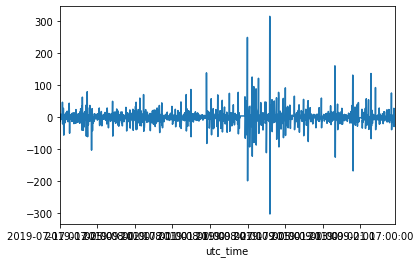

In [90]:
#差分
ts_diff=ts.diff().dropna()
ts_diff.plot()

# ARMAのパラメータ推定

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
param=sm.tsa.arma_order_select_ic(ts_diff, ic="aic", trend="nc")
param

{'aic':               0             1             2
 0           NaN  16290.936098  16194.396191
 1  16346.377362  16105.077120  16106.340900
 2  16278.119576  16106.481470  16109.004138
 3  16249.703857  16103.722111  16102.200246
 4  16233.892186  16105.260006  16101.469205, 'aic_min_order': (4, 2)}

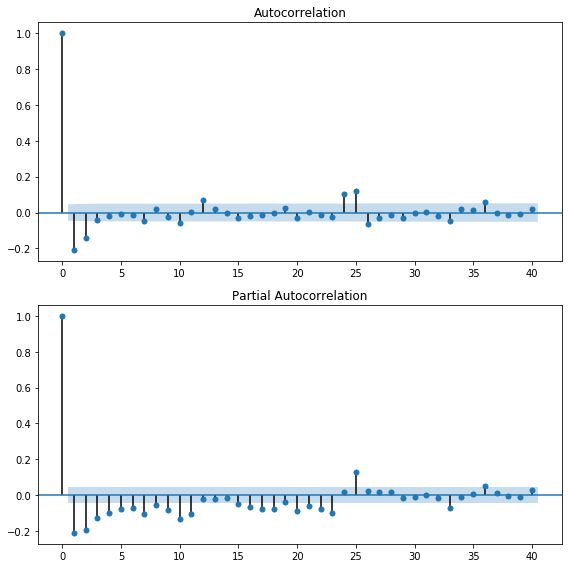

In [93]:
##一回階差の自己相関

fig = plt.figure(figsize=(8, 8))
# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(ts.diff().dropna() , lags=40, ax=ax1) 

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(ts.diff().dropna(), lags=40, ax=ax2) 

plt.tight_layout() 

# SARIMAモデル

In [94]:
sarimax=sm.tsa.SARIMAX(ts,
                      order=(4,1,2),
                      seasonal_order=(1,1,1,24),
                       enforce_stationaly=False,
                       enforce_invertibility = False
                      ).fit()

In [95]:
#モデルの残差
sarimax_resid = sarimax.resid 

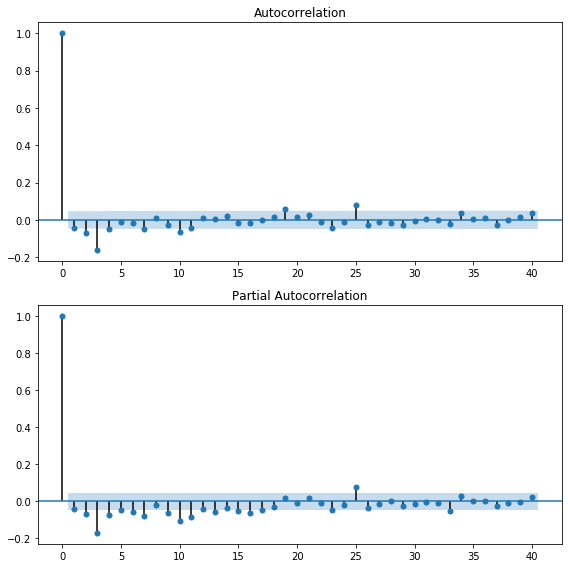

In [96]:
##モデルの残差の自己相関

fig = plt.figure(figsize=(8, 8))
# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid , lags=40, ax=ax1) 

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=40, ax=ax2) 

plt.tight_layout() 

In [97]:
sarimax.aic

15958.038760451687

In [98]:
#sarimax_pred=sarimax.predict("2019-07-19 12:00:00", "2019-09-30 12:00:00")

#7/17 00:00〜09/29 08:00までをtrain
sarimax_pred=sarimax.predict("2019-07-17 00:00:00", "2019-09-29 08:00:00")

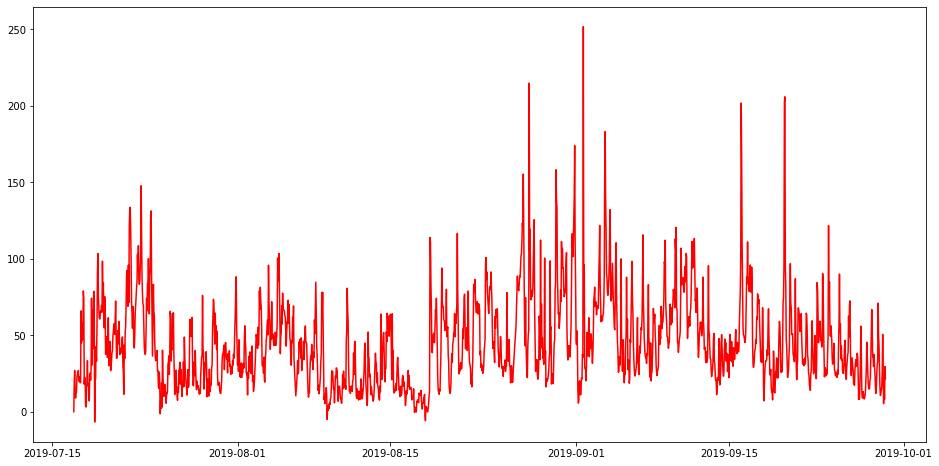

In [99]:
plt.figure(figsize=(16, 8))
plt.plot(sarimax_pred, c="r")


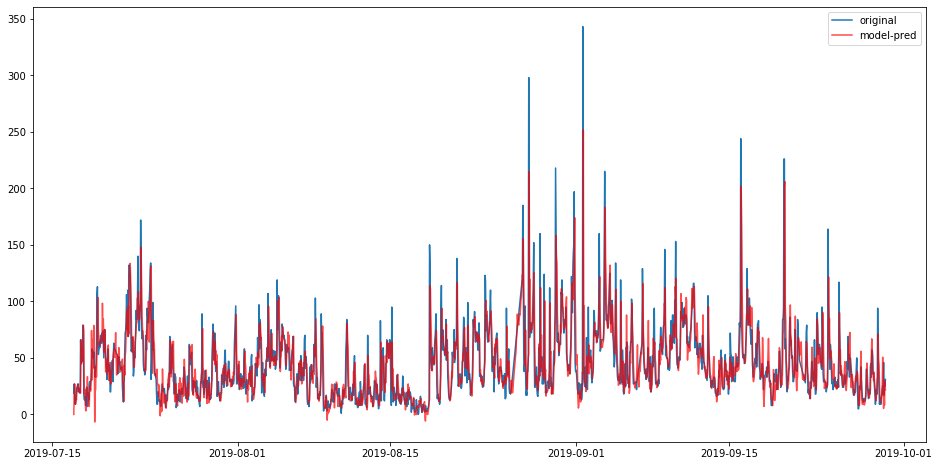

In [108]:
plt.figure(figsize=(16, 8))

plt.plot(ts, label="original")
plt.plot(sarimax_pred, c="r", label="model-pred", alpha=0.7)
plt.legend(loc='best')

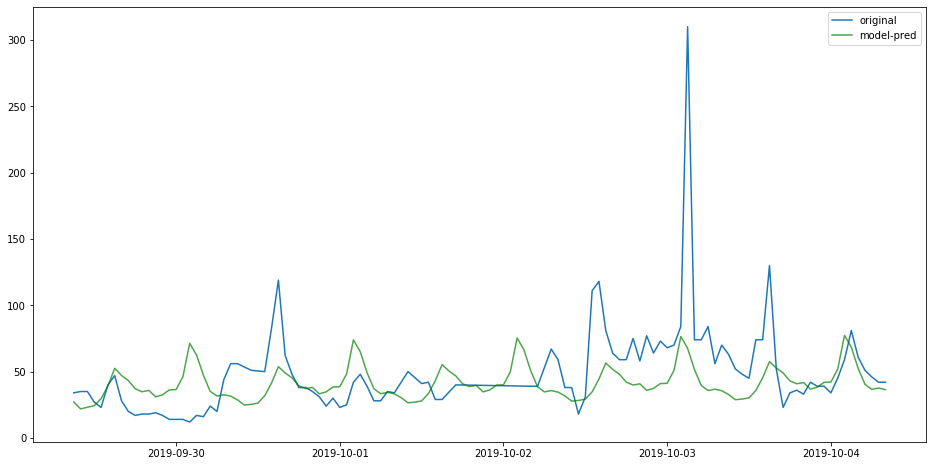

In [128]:
#09/29 09:00　〜 10/04 08:00までの5日間を予測
sarimax_pred_forecast=sarimax.predict("2019-09-29 09:00:00", "2019-10-04 08:00:00")

plt.figure(figsize=(16, 8))
plt.plot(ts_test, label="original")
plt.plot(sarimax_pred_forecast, c="g", label="model-pred", alpha=0.7)
plt.legend(loc='best')

## 観測値・予測値に関するデータフレーム の作成

In [141]:
def aqi_category(x):
    if x>=0 and x<=50:
        return "Good"
    elif x>50 and x<=100:
        return "Satisfactory"
    elif x>100 and x<=200:
        return "Moderately"
    elif x>200 and x<=300:
        return "Poor"
    elif x>300 and x<=400:
        return "VeryPoor"
    elif x>400 :
        return "Severe"

In [204]:
df_forecast=pd.DataFrame(ts_test.values,index=ts_test.index, columns=["original"])
df_forecast["forecast"]=sarimax_pred_forecast

In [205]:
df_forecast

,original,forecast
utc_time,,
2019-09-29 09:00:00,34.0,27.128122
2019-09-29 10:00:00,35.0,21.919087
2019-09-29 11:00:00,35.0,23.156034
2019-09-29 12:00:00,27.0,24.318802
2019-09-29 13:00:00,23.0,29.618051
...,...,...
2019-10-04 04:00:00,61.0,52.486934
2019-10-04 05:00:00,51.0,40.450616
2019-10-04 06:00:00,46.0,36.607883


### 1時間おきにカテゴリー変換して精度を計る

In [206]:
df_forecast["original_category"]=df_forecast["original"].apply(lambda x:aqi_category(x))
df_forecast["forecast_category"]=df_forecast["forecast"].apply(lambda x:aqi_category(x))

In [207]:
df_forecast

,original,forecast,original_category,forecast_category
utc_time,,,,
2019-09-29 09:00:00,34.0,27.128122,Good,Good
2019-09-29 10:00:00,35.0,21.919087,Good,Good
2019-09-29 11:00:00,35.0,23.156034,Good,Good
2019-09-29 12:00:00,27.0,24.318802,Good,Good
2019-09-29 13:00:00,23.0,29.618051,Good,Good
...,...,...,...,...
2019-10-04 04:00:00,61.0,52.486934,Satisfactory,Satisfactory
2019-10-04 05:00:00,51.0,40.450616,Satisfactory,Good
2019-10-04 06:00:00,46.0,36.607883,Good,Good


In [208]:
pd.crosstab(df_forecast["original_category"], df_forecast["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,68,11
Moderately,2,2
Satisfactory,27,9
VeryPoor,0,1


In [209]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_forecast["original_category"], df_forecast["forecast_category"], 
                 labels=["Good", "Satisfactory", "Moderately", "Poor", "VeryPoor",  "Severe"])

array([[68, 11,  0,  0,  0,  0],
       [27,  9,  0,  0,  0,  0],
       [ 2,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])

In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy_score ： {}".format(accuracy_score(df_forecast["original_category"], df_forecast["forecast_category"])))
print("precision_score ： {}".format(precision_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))
print("recall_score ： {}".format(recall_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))
print("f1_score ： {}".format(f1_score(df_forecast["original_category"], df_forecast["forecast_category"], average="micro")))

accuracy_score ： 0.6416666666666667
precision_score ： 0.6416666666666667
recall_score ： 0.6416666666666667
f1_score ： 0.6416666666666667


### 3時間おきにカテゴリー変換して精度を計る

In [211]:
df_forecast3=df_forecast.resample("3H").mean()

In [213]:
df_forecast3["original_category"]=df_forecast3["original"].apply(lambda x:aqi_category(x))
df_forecast3["forecast_category"]=df_forecast3["forecast"].apply(lambda x:aqi_category(x))

In [214]:
pd.crosstab(df_forecast3["original_category"], df_forecast3["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,18,7
Moderately,0,1
Satisfactory,10,4


In [216]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast3["original_category"], df_forecast3["forecast_category"])))

accuracy_score ： 0.55


### 6時間おきにカテゴリー変換して精度を計る

In [217]:
df_forecast6=df_forecast.resample("6H").mean()

df_forecast6["original_category"]=df_forecast6["original"].apply(lambda x:aqi_category(x))
df_forecast6["forecast_category"]=df_forecast6["forecast"].apply(lambda x:aqi_category(x))


In [218]:
pd.crosstab(df_forecast6["original_category"], df_forecast6["forecast_category"])

forecast_category,Good,Satisfactory
original_category,,
Good,12,2
Moderately,0,1
Satisfactory,5,1


In [219]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast6["original_category"], df_forecast6["forecast_category"])))

accuracy_score ： 0.6190476190476191


### 12時間おきにカテゴリー変換して精度を計る

In [220]:
df_forecast12=df_forecast.resample("12H").mean()

df_forecast12["original_category"]=df_forecast12["original"].apply(lambda x:aqi_category(x))
df_forecast12["forecast_category"]=df_forecast12["forecast"].apply(lambda x:aqi_category(x))


In [221]:
pd.crosstab(df_forecast12["original_category"], df_forecast12["forecast_category"])

forecast_category,Good
original_category,
Good,6
Satisfactory,5


In [222]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast12["original_category"], df_forecast12["forecast_category"])))

accuracy_score ： 0.5454545454545454


### 24時間おきにカテゴリー変換して精度を計る

In [224]:
df_forecast24=df_forecast.resample("24H").mean()

df_forecast24["original_category"]=df_forecast24["original"].apply(lambda x:aqi_category(x))
df_forecast24["forecast_category"]=df_forecast24["forecast"].apply(lambda x:aqi_category(x))


In [225]:
pd.crosstab(df_forecast24["original_category"], df_forecast24["forecast_category"])

forecast_category,Good
original_category,
Good,3
Satisfactory,3


In [226]:
print("accuracy_score ： {}".format(accuracy_score(df_forecast24["original_category"], df_forecast24["forecast_category"])))

accuracy_score ： 0.5


## 考察  

- 現状精度は60%前後  
- 外れ値以外は予測できてそう  
- 外れ値は機器の測定不具合な可能性もあり?? 
- GoodとModeratelyはカテゴリの範囲が50なので分類がやや厳しいが、Satisfactory以降は範囲が100なので分類精度は上がりそう  
- 今はRohiniの一観測地点のみを用いているが、州の全観測地点を平均したもの(デリー、ハリアナ州、、)を用いると外れ値は軽減しそう  
- 6時間くらいの平均を取ると、カテゴリの誤分類は1カテゴリ以内で済んでいるのでいいのでは？  


## 今後やること  
- 多くのデータ、パターンで上記の考察、仮説を検証する  
- ARIMAは長期予測に弱いので、予測値を用いて予測モデルを構築するようなモデルを作る